# Multilayer graph modeling of gene expression data

In this notebook you will find the code to replicate the experiments for graph gene classification.

In order to replicate the results you need to uncomment the cell line you wish to replicate.

If you wish to apply the code to your own data, please refer to the pipeline script.

*note*: it will be necessary to change pathways and computer-specific variables in the second cell so that the code will work

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from pathlib import Path
import mygene
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from scipy import stats
from scipy.stats import pearsonr 
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from sklearn.utils import shuffle
import ast
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
import torch
from tqdm import tqdm
import torch.nn as nn
from ast import literal_eval
from xgboost import XGBClassifier
import matplotlib.patches as mpatches
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import pickle
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, global_mean_pool
from torch_geometric.data import Data
import random
from torch.nn import Linear, GELU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import (
    GINEConv, JumpingKnowledge,
    global_mean_pool, global_max_pool
)
from copy import deepcopy
import networkx as nx
from matplotlib import cm
from torch_geometric.utils import to_networkx
from matplotlib.patches import Patch

# Setup

### Change here all directories and paramenters according to your settings

In [ ]:
"""
PARAMETERS TO MODIFY

this code is implemented such that, once you adjust these parameters, you can launch all the code
"""
# ==== Device ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === GENERAL PARAMETERS ===

#select the cell line:
#cell_line = "E003"
#cell_line = "E066"
#cell_line = "E116"

# ======================

# === GNN PARAMETERS ===
np.random.seed(42)
torch.manual_seed(42)

hidden_channels = 256
num_layers      = 2
dropout_p       = 0.30
batch_size      = 64
lr              = 1e-4
weight_decay    = 5e-5
num_folds       = 4
max_epochs      = 30
early_patience  = 20           
val_frac        = 0.15
dropedge_p      = 0.1         
clip_grad_norm  = 1.0
# ===================

# Get data and data formatting

In [ ]:
# final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_pulito_E003.csv") 
# final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_pulito_E066.csv") 
#final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_pulito_E116.csv") 

In [ ]:
#df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_matrice.csv") 
#df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_matrice_E066.csv") 
#df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_matrice_E116.csv") 

# in caso expression la possiamo arrotonadare, come succede per RNA-seq
df['expression'] = df['expression'].round().astype(int)

#features_df = pd.read_csv("features_epigenetiche_per_gene.csv")
#features_df = pd.read_csv("features_epigenetiche_per_gene_E066.csv")
#features_df = pd.read_csv("features_epigenetiche_per_gene_E116.csv")
features_df

node     gene_type  H3K4me1_f0  H3K4me1_f1  H3K4me1_f2  \
0          27286  co-expressed   -0.079440    0.089178   -0.084707   
1           7105          main   -0.077425    0.035563   -0.075661   
2           1266  co-expressed   -0.149155    0.143370   -0.125348   
3          27018  co-expressed   -0.099207    0.058637   -0.060810   
4           4886  co-expressed   -0.103617    0.064496   -0.051016   
...          ...           ...         ...         ...         ...   
13431      51174  co-expressed   -0.094645    0.074262   -0.063492   
13432       5222          main   -0.041259    0.066413   -0.034512   
13433     154288  co-expressed   -0.091746   -0.065662   -0.124170   
13434  100129128          main   -0.083049    0.080254   -0.080037   
13435  100130933          main   -0.219960   -0.068861   -0.126228   

       H3K4me1_f3  H3K4me1_f4  H3K4me1_f5  H3K4me1_f6  H3K4me1_f7  ...  \
0        0.071066   -0.033926    0.056653   -0.095329   -0.002077  ...   
1        0.017960   -0.050275    0.070010   -0.119184    0.003596  ...   
2        0.017255    0.044921    0.035654   -0.451051   -0.132123  ...   
3        0.014431   -0.034697    0.028557   -0.099090    0.001079  ...   
4        0.025089   -0.041889    0.024492   -0.099666    0.026464  ...   
...           ...         ...         ...         ...         ...  ...   
13431    0.030053   -0.028941    0.023321   -0.092151    0.004214  ...   
13432    0.040231   -0.038604    0.027626   -0.094155   -0.000218  ...   
13433    0.074627   -0.075080    0.141151   -0.309071   -0.000592  ...   
13434    0.021812   -0.010977    0.038130   -0.089633   -0.018537  ...   
13435    0.013997   -0.094918    0.082552   -0.310906   -0.012639  ...   

       H3K9me3_f90  H3K9me3_f91  H3K9me3_f92  H3K9me3_f93  H3K9me3_f94  \
0         0.223780     0.047975    -0.091142    -0.021581    -0.065496   
1         0.096893    -0.138565    -0.219266     0.149191     0.029670   
2         0.175289    -0.462186    -0.446254     0.354082    -0.069563   
3         0.122715    -0.063326    -0.172531     0.085976     0.033317   
4         0.185825    -0.041064    -0.164430     0.080081    -0.045825   
...            ...          ...          ...          ...          ...   
13431     0.171928    -0.030058    -0.169699     0.101775    -0.036879   
13432     0.142531     0.048780    -0.107439     0.026139     0.013423   
13433     0.193059     0.059226    -0.151491     0.019695    -0.001610   
13434     0.172559     0.029716    -0.138319     0.023690     0.005412   
13435     0.267823     0.033580    -0.183471     0.025474    -0.058082   

       H3K9me3_f95  H3K9me3_f96  H3K9me3_f97  H3K9me3_f98  H3K9me3_f99  
0        -0.216318     0.006111     0.109385     0.007221     0.042114  
1        -0.189808    -0.027112     0.130762    -0.065570     0.106253  
2        -0.516342    -0.100647     0.153623    -0.108377     0.298764  
3        -0.114747    -0.022276     0.167155    -0.048773     0.100348  
4        -0.232819    -0.050230     0.120589     0.023655     0.093377  
...            ...          ...          ...          ...          ...  
13431    -0.253075    -0.092571     0.048491     0.039677     0.004707  
13432    -0.124671    -0.027678     0.057335     0.040614    -0.073734  
13433    -0.162455    -0.050077     0.139834     0.059116    -0.015958  
13434    -0.167141    -0.047191     0.111668     0.030633    -0.020513  
13435    -0.245598    -0.082905     0.148059     0.083713     0.015124  

[13436 rows x 702 columns]

In [ ]:
#USE THIS CHUNK ONLY FOR E116 

#features_df = features_df.rename(columns={"node": "entrez_id"})

#features_df["entrez_id"] = features_df["entrez_id"].astype(str).str.replace("_aggregate", "", regex=False)
#features_df

In [18]:
features_df['entrez_id'] = features_df['node'].astype(str)
features_df = features_df.drop(columns="gene_type")

df_unique = df.drop_duplicates(subset='entrez_id').copy()
df_unique['entrez_id'] = df_unique['entrez_id'].astype(str)

merged_df = pd.merge(df_unique, features_df, on='entrez_id', how='inner')
merged_df

gene_id  expression   eid  label  chrom      start        end  \
0      ENSG00000000003          44  E003      1   chrX   99891803   99891804   
1      ENSG00000000005           2  E003      0   chrX   99839931   99839932   
2      ENSG00000000457           3  E003      0   chr1  169863037  169863038   
3      ENSG00000000460           7  E003      1   chr1  169764179  169764180   
4      ENSG00000000938           0  E003      0   chr1   27953108   27953109   
...                ...         ...   ...    ...    ...        ...        ...   
11811  ENSG00000258818           2  E003      0  chr14   21152717   21152718   
11812  ENSG00000258839           1  E003      0  chr16   89985268   89985269   
11813  ENSG00000258890          26  E003      1  chr17   62503093   62503094   
11814  ENSG00000258947          35  E003      1  chr16   89988331   89988332   
11815  ENSG00000259120           0  E003      0  chr17   73642329   73642330   

      strand  split                                          neighbors  ...  \
0          -      4                                                NaN  ...   
1          +      4                                                NaN  ...   
2          -      1  chr1:170616799-170620074;chr1:170575489-170580...  ...   
3          +      1  chr1:169497108-169500425;chr1:169590775-169597...  ...   
4          -      1  chr1:27383252-27390061;chr1:27744472-27751372;...  ...   
...      ...    ...                                                ...  ...   
11811      +      1  chr14:21127322-21131085;chr14:21089191-2109805...  ...   
11812      +      3  chr16:90050224-90062361;chr16:89878245-8989408...  ...   
11813      +      4  chr17:62471061-62475206;chr17:62475207-6247940...  ...   
11814      +      3  chr16:90050224-90062361;chr16:89878245-8989408...  ...   
11815      +      4  chr17:73667136-73672961;chr17:73736356-7374105...  ...   

      H3K9me3_f90 H3K9me3_f91 H3K9me3_f92 H3K9me3_f93  H3K9me3_f94  \
0        0.096893   -0.138565   -0.219266    0.149191     0.029670   
1        0.129602    0.042729   -0.117599    0.042401     0.015104   
2        0.193079   -0.118917   -0.230074    0.217112    -0.109970   
3        0.165328   -0.155847   -0.276086    0.235031    -0.075027   
4        0.299000    0.012823   -0.188857   -0.045220    -0.038449   
...           ...         ...         ...         ...          ...   
11811    0.251515   -0.063413   -0.223180    0.258068    -0.164007   
11812    0.251122   -0.038579   -0.260169    0.088392    -0.075848   
11813    0.413388   -0.270492   -0.330205    0.494373    -0.439320   
11814    0.222226   -0.076826   -0.241238    0.103674    -0.052379   
11815    0.267823    0.033580   -0.183471    0.025474    -0.058082   

       H3K9me3_f95  H3K9me3_f96  H3K9me3_f97  H3K9me3_f98  H3K9me3_f99  
0        -0.189808    -0.027112     0.130762    -0.065570     0.106253  
1        -0.132821    -0.035597     0.071426     0.020868    -0.024360  
2        -0.420660    -0.152954    -0.040019     0.043408     0.058393  
3        -0.389749    -0.145259     0.053030     0.004916     0.115835  
4        -0.261751    -0.042925     0.124743     0.061450    -0.035571  
...            ...          ...          ...          ...          ...  
11811    -0.497543    -0.223333    -0.057026     0.120652     0.068362  
11812    -0.359521    -0.081095     0.161317     0.050646     0.105802  
11813    -0.992795    -0.397149    -0.234153     0.181422     0.245008  
11814    -0.311432    -0.061253     0.143151     0.025180     0.114340  
11815    -0.245598    -0.082905     0.148059     0.083713     0.015124  

[11816 rows x 715 columns]

In [19]:
final_df = merged_df

# Classification: method 1 - XGBoost

In [ ]:
X = []
y = []
splits = []

histone_cols = [col for col in final_df.columns if any(mark in col for mark in [
    "H3K4me1", "H3K4me3", "H3K9ac", "H3K27ac", "H3K27me3", "H3K36me3", "H3K9me3"
])]

for idx, row in final_df.iterrows():
    raw_matrix = row['matrice_correlazioni']

    try:
        # Parsing matrice
        if isinstance(raw_matrix, str):
            matrice = ast.literal_eval(raw_matrix)
        elif isinstance(raw_matrix, list):
            matrice = raw_matrix
        else:
            continue

        if not (isinstance(matrice, list) and all(isinstance(r, list) for r in matrice)):
            continue

        # Flatten correlation matrix
        matrice_flattened = np.array(matrice).flatten()

        # extract features
        histone_features = row.loc[histone_cols].astype(float).values

        # concatenation
        features = np.concatenate([matrice_flattened, histone_features])

        X.append(features)
        y.append(row['label'])
        splits.append(row['split'])

    except Exception as e:
        print(f"⚠️ Errore alla riga {idx}: {e}")
        continue

# final conversion
X = np.array(X)
y = np.array(y)
splits = np.array(splits)

⚠️ Errore alla riga 877: malformed node or string on line 1: <ast.Name object at 0x000002CC65D684D0>


In [ ]:
X = []
y = []
splits = []

histone_cols = [col for col in final_df.columns if any(mark in col for mark in [
    "H3K4me1", "H3K4me3", "H3K9ac", "H3K27ac", "H3K27me3", "H3K36me3", "H3K9me3"
])]

def get_histone_features(entrez_id):
    row_feat = features_df[features_df['entrez_id'] == entrez_id]
    if row_feat.empty:
        return None
    return row_feat[histone_cols].values.flatten()

for idx, row in final_df.iterrows():
    raw_matrix = row['matrice_correlazioni']

    try:
        
        if isinstance(raw_matrix, str):
            matrice = ast.literal_eval(raw_matrix)
        elif isinstance(raw_matrix, list):
            matrice = raw_matrix
        else:
            continue

        if not (isinstance(matrice, list) and all(isinstance(r, list) for r in matrice)):
            continue

        
        matrice_flattened = np.array(matrice).flatten()

        
        gene_feature_vectors = []

        #main gene
        main_id = str(row['entrez_id'])
        main_feats = get_histone_features(main_id)
        if main_feats is not None:
            gene_feature_vectors.append(main_feats)

        # Gene coexèpressed
        coexpr = row.get('co-espressione', '')
        if isinstance(coexpr, str):
            for g in coexpr.split(','):
                g = g.strip()
                if not g:
                    continue
                co_feats = get_histone_features(g)
                if co_feats is not None:
                    gene_feature_vectors.append(co_feats)

        if not gene_feature_vectors:
            continue

        # concatenation all features
        histone_features = np.concatenate(gene_feature_vectors)

        # final concatenation: [matrice_correlazione | histone_features]
        features = np.concatenate([matrice_flattened, histone_features])
        
        # dataset
        X.append(features)
        y.append(row['label'])
        splits.append(row['split'])

    except Exception as e:
        print(f"⚠️ Errore alla riga {idx}: {e}")
        continue

# Conversione finale in array numpy
X = np.array(X)
y = np.array(y)
splits = np.array(splits)

⚠️ Errore alla riga 877: malformed node or string on line 1: <ast.Name object at 0x000002CC65D6A1D0>


In [22]:
X.shape

(11815, 3584)

In [ ]:
# XGBoost classifier definition
xgb_clf = XGBClassifier(
    n_estimators=500, 
    max_depth=5,
    eval_metric='logloss',
    random_state=42
)

# Cross-Validation
xgb_scores = []
xgb_auc_scores = []
xgb_precision_scores = []
xgb_recall_scores = []
xgb_f1_scores = []

for fold in range(1, 5):
    test_idx = np.where(splits == fold)[0]
    train_idx = np.where(splits != fold)[0]
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    y_prob = xgb_clf.predict_proba(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    xgb_scores.append(acc)
    
    # AUC score
    if len(np.unique(y)) == 2:
        auc = roc_auc_score(y_test, y_prob[:, 1])
    else:
        auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    xgb_auc_scores.append(auc)
    
    # Precision
    precision = precision_score(y_test, y_pred, average='binary' if len(np.unique(y)) == 2 else 'macro')
    xgb_precision_scores.append(precision)
    
    # Recall
    recall = recall_score(y_test, y_pred, average='binary' if len(np.unique(y)) == 2 else 'macro')
    xgb_recall_scores.append(recall)
    
    # F1 Score
    f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y)) == 2 else 'macro')
    xgb_f1_scores.append(f1)

# Print the results
print("XGBoost Cross-Validation Accuracy Scores:", xgb_scores)
print("XGBoost Mean Accuracy:", np.mean(xgb_scores))

print("XGBoost Cross-Validation AUC Scores:", xgb_auc_scores)
print("XGBoost Mean AUC:", np.mean(xgb_auc_scores))

print("XGBoost Cross-Validation Precision Scores:", xgb_precision_scores)
print("XGBoost Mean Precision:", np.mean(xgb_precision_scores))

print("XGBoost Cross-Validation Recall Scores:", xgb_recall_scores)
print("XGBoost Mean Recall:", np.mean(xgb_recall_scores))

print("XGBoost Cross-Validation F1 Scores:", xgb_f1_scores)
print("XGBoost Mean F1:", np.mean(xgb_f1_scores))

XGBoost Cross-Validation Accuracy Scores: [0.9158291457286433, 0.910752688172043, 0.9190927555856466, 0.9037062694838933]
XGBoost Mean Accuracy: 0.9123452147425566
XGBoost Cross-Validation AUC Scores: [0.9669884620514873, 0.9666923314497993, 0.9675208742722312, 0.9519247596276137]
XGBoost Mean AUC: 0.9632816068502829
XGBoost Cross-Validation Precision Scores: [0.9325153374233128, 0.9210977701543739, 0.934640522875817, 0.9184692179700499]
XGBoost Mean Precision: 0.9266807121058884
XGBoost Cross-Validation Recall Scores: [0.9306122448979591, 0.9355400696864111, 0.935149863760218, 0.9266927811975377]
XGBoost Mean Recall: 0.9319987398855315
XGBoost Cross-Validation F1 Scores: [0.9315628192032687, 0.9282627484874676, 0.9348951239444293, 0.9225626740947075]
XGBoost Mean F1: 0.9293208414324683


# Classification: method 2 - GNN

## T-test

In [ ]:
#final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_matrice.csv") 
#final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_matrice_E066.csv") 
#final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/geni_matrice_E116.csv") 


#final_df = pd.read_csv("C:/Users/stefa/OneDrive/Desktop/final_df_E116_ultimi_coexp.csv") 

In [19]:
# Estrai le matrici e le label
X = []
labels = []

for _, row in final_df.iterrows():
    try:
        matrice = ast.literal_eval(row['matrice_correlazioni'])
        if isinstance(matrice, list) and all(isinstance(r, list) for r in matrice):
            arr = np.array(matrice)
            if arr.shape == (28, 28):
                X.append(arr)
                labels.append(row['label'])
    except:
        continue

X = np.array(X)
labels = np.array(labels)

# Controlli di base
if X.ndim != 3 or X.shape[0] < 2 or len(np.unique(labels)) < 2:
    raise ValueError("Dati insufficienti o malformati")

# Divisione in gruppi
group0 = X[labels == 0]
group1 = X[labels == 1]

# T-test elemento per elemento (escludendo la diagonale)
t_stats = np.zeros((28, 28))
p_values = np.ones((28, 28))

for i in range(28):
    for j in range(28):
        if i == j:
            continue  # Salta la diagonale
        try:
            vals0 = group0[:, i, j]
            vals1 = group1[:, i, j]
            stat, p = ttest_ind(vals0, vals1, equal_var=False)
            t_stats[i, j] = stat
            p_values[i, j] = p
        except:
            continue

# Correzione multipla
p_flat = p_values.flatten()
_, p_adj_flat, _, _ = multipletests(p_flat, method='fdr_bh')
p_adj = p_adj_flat.reshape(28, 28)

# Imposta la diagonale a NaN per evitare disturbo nella heatmap
for i in range(28):
    p_adj[i, i] = np.nan

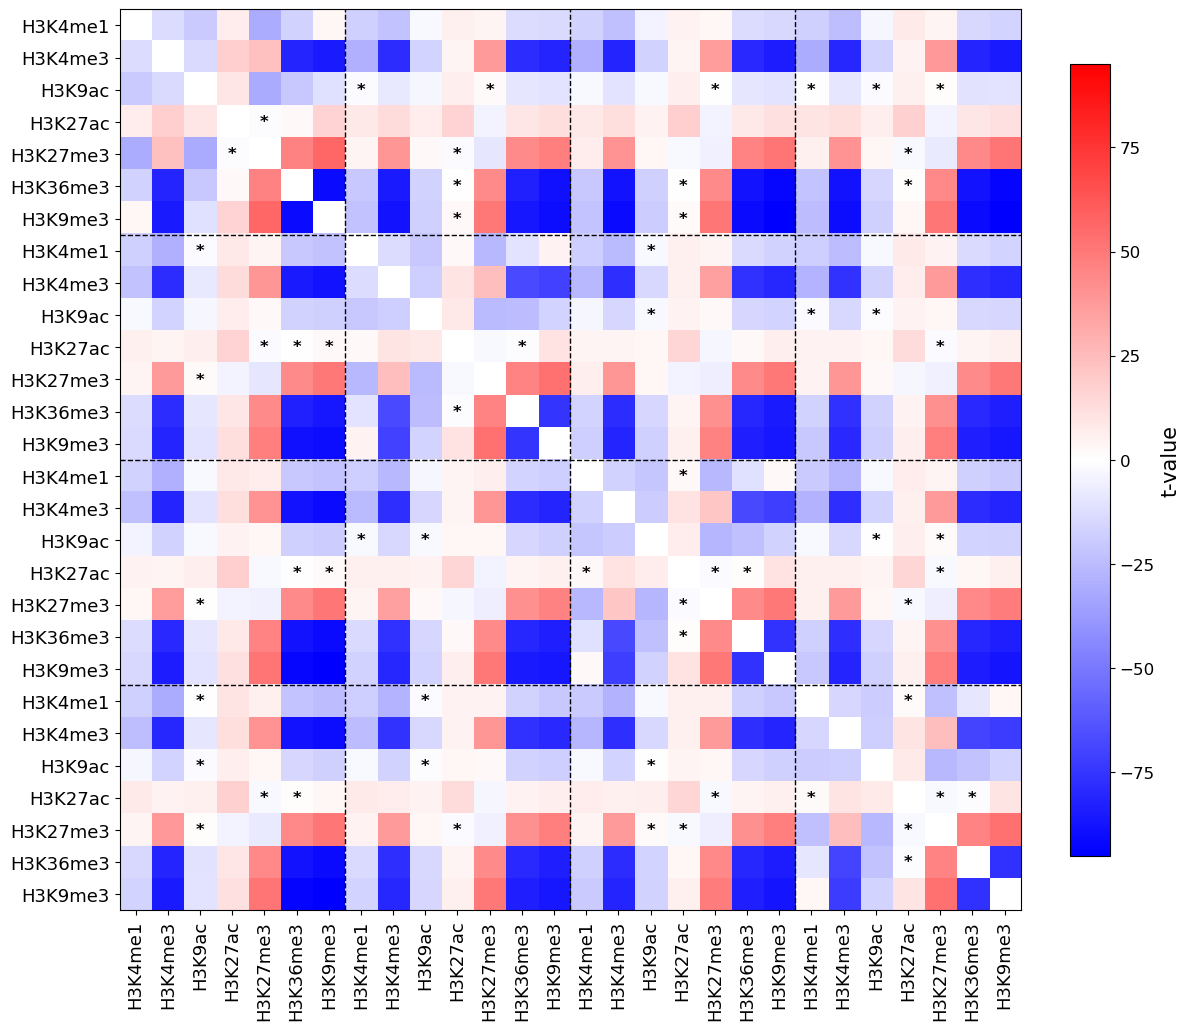

In [20]:
# 1) Diagonale a NaN
np.fill_diagonal(t_stats, np.nan)

# 2) Normalizzazione simmetrica
abs_max = np.nanmax(np.abs(t_stats))
norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

# 3) Colormap blu-bianco-rosso
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_red_white_blue", ["blue", "white", "red"]
)

# 4) Etichette istone (ripetute per ogni blocco da 7)
modifiche_istone = ["H3K4me1", "H3K4me3", "H3K9ac",
                    "H3K27ac", "H3K27me3", "H3K36me3", "H3K9me3"]
n_mod = len(modifiche_istone)
n_geni = 28 // n_mod
tick_labels = modifiche_istone * n_geni  # 7 etichette ripetute 4 volte

# 5) Plot
fig, ax = plt.subplots(figsize=(12, 12))  # grande per leggere bene le label
im = ax.imshow(t_stats, cmap=custom_cmap, norm=norm)

# 6) Colorbar con label grande
# 6) Colorbar più piccola
cbar = plt.colorbar(im, ax=ax, fraction=0.04, shrink=0.8, pad=0.05)
cbar.set_label('t-value', fontsize=15)
cbar.ax.tick_params(labelsize=12)

# 7) Tick + etichette come nel tuo seaborn
ax.set_xticks(range(28))
ax.set_yticks(range(28))
ax.set_xticklabels(tick_labels, rotation=90, fontsize=13)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=13)

# 8) Asterischi dove p_adj ≥ 0.01
for i in range(28):
    for j in range(28):
        if i != j and p_adj[i, j] >= 0.01:
            ax.text(j, i, '*', ha='center', va='center',
                    color='black', fontsize=12, fontweight='bold')

# 9) Linee tratteggiate ogni 7 per separare i blocchi
for k in range(1, n_geni):
    ax.axvline(x=n_mod * k - 0.5, color='black', linestyle='--', lw=1)
    ax.axhline(y=n_mod * k - 0.5, color='black', linestyle='--', lw=1)

plt.tight_layout()
plt.show()

### permutation test

Permutation p-value (mean|t|) = 0.000999


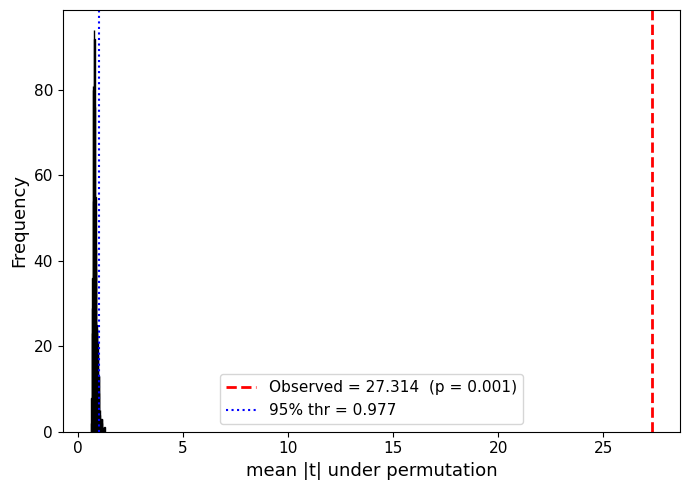

In [ ]:
N_PERM = 1000
rng = np.random.default_rng(42)

iu = np.triu_indices(28, k=1)

obs_mean = np.nanmean(np.abs(t_stats[iu]))

# null distribution
null_mean = np.empty(N_PERM)

for b in range(N_PERM):
    perm = rng.permutation(labels)
    gp0 = X[perm == 0]
    gp1 = X[perm == 1]

    t_vals = []
    for i, j in zip(*iu):
        vals0 = gp0[:, i, j]
        vals1 = gp1[:, i, j]
        tt, _ = ttest_ind(vals0, vals1, equal_var=False)
        t_vals.append(abs(tt))

    null_mean[b] = np.nanmean(t_vals)

# p-value
p_val = (1 + np.sum(null_mean >= obs_mean)) / (N_PERM + 1)
print(f"Permutation p-value (mean|t|) = {p_val:.4g}")

plt.figure(figsize=(7,5))
plt.hist(null_mean, bins=40, color='lightgray', edgecolor='black')
plt.axvline(obs_mean, color='red', lw=2, ls='--',
            label=f'Observed = {obs_mean:.3f}  (p = {p_val:.2g})')
q95 = np.quantile(null_mean, 0.95)
plt.axvline(q95, color='blue', ls=':',
            label=f'95% thr = {q95:.3f}')
plt.xlabel('mean |t| under permutation', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Adjacency Matrix creation

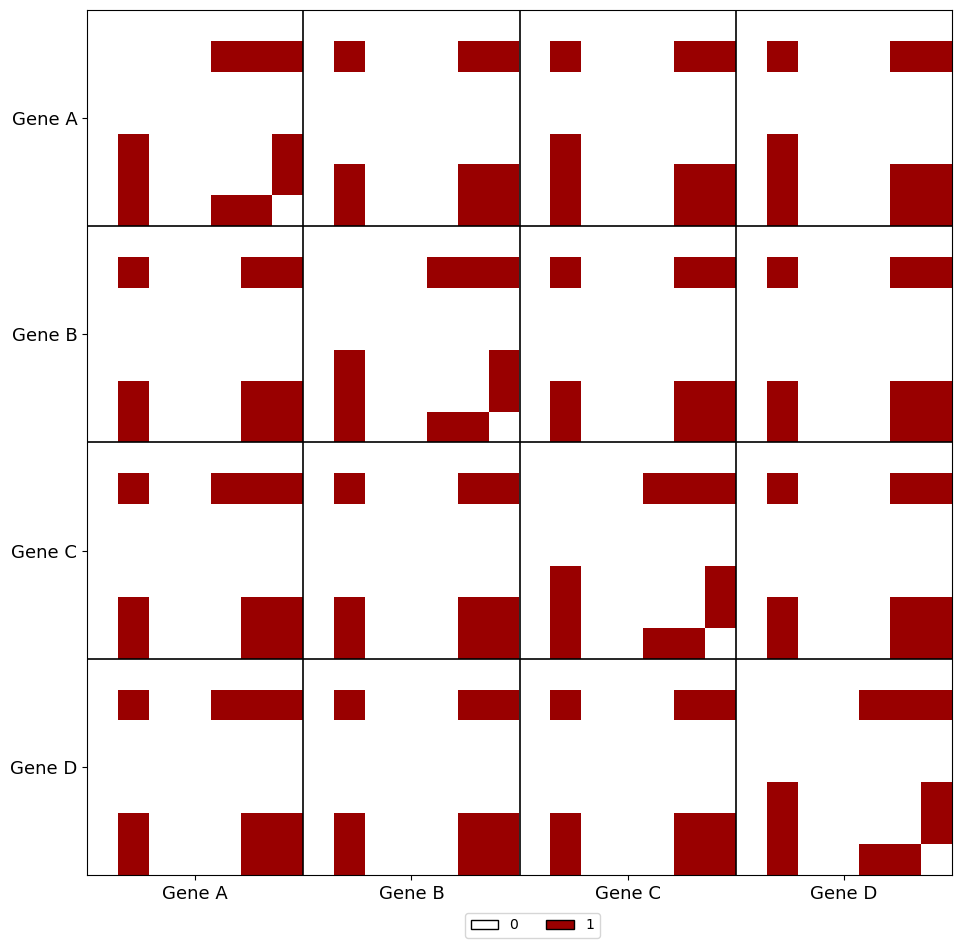

In [ ]:
# parameters
threshold = 40  # valore assoluto del t-test
p_threshold = 0.01  # p-value corretto per FDR

# === 1. ìComputation ===
# Usa t_stats e p_adj dal t-test originale 28x28
adj_matrix_28 = ((np.abs(t_stats) > threshold) & (p_adj < p_threshold)).astype(int)

# diagonal 0
np.fill_diagonal(adj_matrix_28, 0)

# === 2. Plot 28x28 ===
fig, ax = plt.subplots(figsize=(10, 10))

# Colormap
cmap = LinearSegmentedColormap.from_list("smooth_red", ["#ffffff", "#ffcccc", "#990000"])
im = ax.imshow(adj_matrix_28, cmap=cmap)

n_nodes = 7
n_layers = 4
tick_pos = [n_nodes * i + n_nodes // 2 for i in range(n_layers)]
tick_labels = ["Gene A", "Gene B", "Gene C", "Gene D"]
ax.set_xticks(tick_pos)
ax.set_yticks(tick_pos)
ax.set_xticklabels(tick_labels, fontsize=13)
ax.set_yticklabels(tick_labels, fontsize=13)

ax.set_xticks(np.arange(n_layers * n_nodes), minor=True)
ax.set_yticks(np.arange(n_layers * n_nodes), minor=True)
ax.tick_params(which="minor", bottom=False, left=False)

for l in range(1, n_layers):
    ax.axhline(l * n_nodes - 0.5, color='black', linewidth=1.2)
    ax.axvline(l * n_nodes - 0.5, color='black', linewidth=1.2)

legend_elements = [
    mpatches.Patch(facecolor="#ffffff", edgecolor='black', label="0"),
    mpatches.Patch(facecolor="#990000", edgecolor='black', label="1")
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=10, frameon=True, bbox_to_anchor=(0.55, 0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.12) 
plt.show()

## GNN

### Setup for the GNN

In [ ]:
#df = pd.read_csv("geni_matrice.csv")
#righe_da_saltare = [877, 1976, 6978, 8439, 9751, 11061, 11542]
#df = df.drop(index=righe_da_saltare).reset_index(drop=True)
#df

#df = pd.read_csv("geni_matrice_E066.csv")
#df

#df = pd.read_csv("geni_matrice_E116.csv")
#df

gene_id  expression   eid  label  chrom      start        end  \
0      ENSG00000000003       0.038  E116      0   chrX   99891803   99891804   
1      ENSG00000000005       0.000  E116      0   chrX   99839931   99839932   
2      ENSG00000000457      11.082  E116      1   chr1  169863037  169863038   
3      ENSG00000000460      13.743  E116      1   chr1  169764179  169764180   
4      ENSG00000000938      98.303  E116      1   chr1   27953108   27953109   
...                ...         ...   ...    ...    ...        ...        ...   
11817  ENSG00000258818       0.908  E116      0  chr14   21152717   21152718   
11818  ENSG00000258839       0.329  E116      0  chr16   89985268   89985269   
11819  ENSG00000258890      21.644  E116      1  chr17   62503093   62503094   
11820  ENSG00000258947       0.376  E116      0  chr16   89988331   89988332   
11821  ENSG00000259120       1.560  E116      0  chr17   73642329   73642330   

      strand  split                                          neighbors  \
0          -      4                                                NaN   
1          +      4                                                NaN   
2          -      1  chr1:170861787-170871823;chr1:170810906-170815...   
3          +      1  chr1:168550558-168560926;chr1:170861787-170871...   
4          -      1  chr1:27744472-27751372;chr1:27724126-27728304;...   
...      ...    ...                                                ...   
11817      +      1  chr14:21131086-21137483;chr14:21089191-2109805...   
11818      +      3  chr16:89748500-89753609;chr16:90050224-9006236...   
11819      +      4  chr17:62633144-62637916;chr17:62625450-6263314...   
11820      +      3  chr16:89748500-89753609;chr16:90050224-9006236...   
11821      +      4  chr17:73667136-73672961;chr17:73698918-7370728...   

                                                  scores  entrez_id  \
0                                                    NaN       7105   
1                                                    NaN      64102   
2                            1.6897;1.6651;1.5914;1.5681      57147   
3                                   1.5144;1.5077;1.5048      55732   
4      2.1425;2.1091;2.1017;2.0174;1.9352;1.8936;1.86...       2268   
...                                                  ...        ...   
11817  3.7358;3.3108;3.2019;2.8459;2.8299;2.426;2.353...       6038   
11818  3.0194;2.737;2.6932;2.3552;2.0931;1.9735;1.94;...       4157   
11819  2.8741;2.8195;2.5225;2.256;2.1322;2.1009;2.100...      90799   
11820  3.0194;2.737;2.6932;2.3552;2.0931;1.9735;1.94;...      10381   
11821  4.297;3.3018;3.0478;3.0405;3.0124;2.8662;2.793...  100130933   

           co-espressione                               matrice_correlazioni  
0        27286,27018,1266  [[1.0, 0.27352259029270853, 0.0782571095303360...  
1         9370,4886,10345  [[0.9999999999999999, 0.08832596510152678, 0.0...  
2        92344,25896,8548  [[0.9999999999999999, 0.12472055671032883, 0.0...  
3      286826,253714,2491  [[1.0, 0.19410943837598973, 0.1200008387496029...  
4         3101,3687,10288  [[1.0, 0.38621019296561265, 0.1560829954657618...  
...                   ...                                                ...  
11817     283,92689,10954  [[1.0, 0.30679415352421174, 0.1892333253170229...  
11818    10381,84501,9311  [[1.0, 0.4639135783850369, 0.00110121584316817...  
11819   11011,23360,57602  [[0.9999999999999998, 0.18347840270745974, 0.1...  
11820     4157,7280,79007  [[1.0, 0.45425135778352416, -0.004015835294866...  
11821     53841,745,10110  [[1.0, 0.5132575423383523, 0.21860949086799344...  

[11822 rows x 14 columns]

In [ ]:
#info_data_completo = pd.read_csv('C:/Users/stefa/OneDrive/Desktop/geni_pulito_E003.csv')
#info_data_completo

#info_data_completo = pd.read_csv('C:/Users/stefa/OneDrive/Desktop/geni_pulito_E066.csv')
#info_data_completo

#info_data_completo = pd.read_csv('C:/Users/stefa/OneDrive/Desktop/geni_pulito_E116.csv')
#info_data_completo

gene_id  expression   eid  label  chrom      start        end  \
0      ENSG00000000003       0.038  E116      0   chrX   99891803   99891804   
1      ENSG00000000005       0.000  E116      0   chrX   99839931   99839932   
2      ENSG00000000419      79.197  E116      1  chr20   49575101   49575102   
3      ENSG00000000457      11.082  E116      1   chr1  169863037  169863038   
4      ENSG00000000460      13.743  E116      1   chr1  169764179  169764180   
...                ...         ...   ...    ...    ...        ...        ...   
14286  ENSG00000258920       0.907  E116      0  chr14   89883696   89883697   
14287  ENSG00000258947       0.376  E116      0  chr16   89988331   89988332   
14288  ENSG00000259120       1.560  E116      0  chr17   73642329   73642330   
14289  ENSG00000259207       8.684  E116      1  chr17   45331191   45331192   
14290  ENSG00000259431       2.602  E116      1  chr14   24025189   24025190   

      strand  split                                          neighbors  \
0          -      4                                                NaN   
1          +      4                                                NaN   
2          -      3  chr20:49408303-49420667;chr20:49930810-4993724...   
3          -      1  chr1:170861787-170871823;chr1:170810906-170815...   
4          +      1  chr1:168550558-168560926;chr1:170861787-170871...   
...      ...    ...                                                ...   
14286      +      1                            chr14:90082294-90092211   
14287      +      3  chr16:89748500-89753609;chr16:90050224-9006236...   
14288      +      4  chr17:73667136-73672961;chr17:73698918-7370728...   
14289      +      4  chr17:45735626-45738934;chr17:44810688-4481381...   
14290      +      1  chr14:23563094-23567316;chr14:23962614-2397131...   

                                                  scores  entrez_id  \
0                                                    NaN       7105   
1                                                    NaN      64102   
2      3.189;2.209;2.0434;2.0214;1.848;1.763;1.7583;1...       8813   
3                            1.6897;1.6651;1.5914;1.5681      57147   
4                                   1.5144;1.5077;1.5048      55732   
...                                                  ...        ...   
14286                                             2.3681     400236   
14287  3.0194;2.737;2.6932;2.3552;2.0931;1.9735;1.94;...      10381   
14288  4.297;3.3018;3.0478;3.0405;3.0124;2.8662;2.793...  100130933   
14289                               1.6418;1.5638;1.5125       3690   
14290  2.1333;1.9747;1.956;1.881;1.84;1.8218;1.8119;1...      79178   

                  co-espressione  
0               27286,27018,1266  
1                9370,4886,10345  
2               8520,51639,57129  
3               92344,25896,8548  
4             286826,253714,2491  
...                          ...  
14286  79178,101926888,100507437  
14287            4157,7280,79007  
14288            53841,745,10110  
14289      124989,5473,107984360  
14290     102724814,283377,26277  

[14291 rows x 13 columns]

In [ ]:
#features_df = pd.read_csv("features_epigenetiche_per_gene.csv")
#features_df

#features_df = pd.read_csv("features_epigenetiche_per_gene_E066.csv")
#features_df

#features_df = pd.read_csv("features_epigenetiche_per_gene_E116.csv")
#features_df
#features_df["node"] = features_df["node"].astype(str).str.replace("_aggregate", "", regex=False)
#features_df

node  H3K4me1_f0  H3K4me1_f1  H3K4me1_f2  H3K4me1_f3  H3K4me1_f4  \
0       5495    0.015042   -0.105528    0.104516    0.036577    0.014459   
1       6331   -0.008547   -0.044791    0.065512   -0.017840   -0.008227   
2      92070    0.006963    0.005706    0.081760    0.135557   -0.028900   
3      10975   -0.022843   -0.102892    0.085359    0.037361   -0.031824   
4       2287   -0.061861   -0.052944    0.071379    0.027083   -0.046482   
...      ...         ...         ...         ...         ...         ...   
15743  55906   -0.020751   -0.046727    0.048865   -0.033664   -0.014026   
15744  54841   -0.009033   -0.122653    0.186781    0.030236    0.008555   
15745  51816   -0.190054   -0.118627    0.286424   -0.017736   -0.114198   
15746   3640   -0.024655   -0.040733    0.064651   -0.024052   -0.003610   
15747  23318   -0.045652   -0.057280    0.150506    0.001817   -0.027822   

       H3K4me1_f5  H3K4me1_f6  H3K4me1_f7  H3K4me1_f8  ...  H3K9me3_f90  \
0        0.102694    0.169369   -0.008814    0.043997  ...    -0.036763   
1        0.010416    0.103204   -0.007540   -0.001421  ...    -0.058254   
2        0.050882    0.224213    0.000264   -0.077824  ...    -0.211749   
3       -0.046194    0.200885   -0.057743   -0.039348  ...     0.092508   
4        0.024519    0.190527    0.064273   -0.024587  ...    -0.167534   
...           ...         ...         ...         ...  ...          ...   
15743    0.030559    0.077082    0.011431    0.005980  ...    -0.072218   
15744    0.036347    0.150116   -0.042194    0.024379  ...    -0.005635   
15745   -0.095869    0.275877   -0.117725   -0.151243  ...    -0.037743   
15746    0.022139    0.066822    0.024182    0.037727  ...    -0.050500   
15747    0.069740    0.140324   -0.041202   -0.029762  ...    -0.058585   

       H3K9me3_f91  H3K9me3_f92  H3K9me3_f93  H3K9me3_f94  H3K9me3_f95  \
0         0.039764     0.001947     0.106761     0.023855    -0.016578   
1        -0.005996    -0.023929    -0.032204     0.006352     0.014998   
2         0.068642     0.032695    -0.118323     0.198408     0.093461   
3        -0.051698    -0.135386     0.209824     0.187047    -0.187795   
4         0.042823     0.027983    -0.074247     0.131274     0.055320   
...            ...          ...          ...          ...          ...   
15743     0.010094    -0.009628    -0.039455     0.016227     0.028150   
15744     0.053302     0.002259     0.127870     0.024719    -0.032484   
15745     0.039178     0.033844     0.072400    -0.029143    -0.008083   
15746    -0.004549    -0.011527    -0.025317    -0.003752     0.012307   
15747     0.040480     0.009621     0.045544     0.046954     0.003939   

       H3K9me3_f96  H3K9me3_f97  H3K9me3_f98  H3K9me3_f99  
0        -0.038060     0.130308     0.185164    -0.175867  
1        -0.047897     0.121553    -0.001429    -0.104830  
2        -0.102178     0.307458     0.241173     0.145229  
3        -0.082838    -0.026347     0.012678    -0.394940  
4        -0.054348     0.242103     0.183640     0.027993  
...            ...          ...          ...          ...  
15743    -0.060898     0.116788     0.007802    -0.071964  
15744    -0.045967     0.070457     0.149461    -0.219097  
15745    -0.051272     0.110556     0.092154    -0.176462  
15746    -0.057909     0.112888    -0.008192    -0.101788  
15747    -0.041231     0.140358     0.125073    -0.121610  

[15748 rows x 701 columns]

In [ ]:

node_to_index = {}
histone_marks = ["H3K4me1", "H3K4me3", "H3K9ac", "H3K27ac", "H3K27me3", "H3K36me3", "H3K9me3"]


for idx, row in features_df.iterrows():
    gene_id = row['node'] 
    for mark in histone_marks:
        node_name = f"{gene_id}_{mark}"  
        node_to_index[node_name] = idx

# verification correct creation
test_gene = '27286' 
test_mark = 'H3K4me1' 
test_node = f"{test_gene}_{test_mark}"  

if test_node in node_to_index:
    index = node_to_index[test_node]
    print(f"Indice del nodo {test_node}: {index}")
    
    
    start_col = features_df.columns.get_loc(f"{test_mark}_f0")  
    end_col = features_df.columns.get_loc(f"{test_mark}_f99") + 1  
    
    
    node_features = features_df.iloc[index, start_col:end_col].values  
    print(f"Feature per il nodo {test_node}: {node_features}")
    
    # Debug
    print(f"Lunghezza delle caratteristiche per il nodo {test_node}: {len(node_features)}")
else:
    print(f"Il nodo {test_node} non esiste nella mappa!")


Indice del nodo 27286_H3K4me1: 5273
Feature per il nodo 27286_H3K4me1: [-0.0424966141581535 -0.0733852088451385 0.1597399711608886
 -0.0595768019556999 0.0034260898828506 0.0444234460592269
 0.02488948777318 -0.0144472979009151 0.0106359189376235
 -0.0399553775787353 -0.0282319206744432 -0.0599419362843036
 0.0795234143733978 0.010044440627098 0.0704179480671882
 -0.0809787288308143 -0.0106887146830558 -0.0756665766239166
 -0.0123607143759727 0.1518984735012054 0.1346493363380432
 -0.1056325435638427 0.0899349972605705 -0.0149738937616348
 -0.0075830863788723 -0.0627777278423309 0.0268273763358593
 0.0538185611367225 -0.0665605291724205 0.0633975118398666
 0.0358701720833778 -0.0783748030662536 -0.0625653862953186
 0.0186145305633544 -0.1915726065635681 0.0702902600169181
 -0.0450021885335445 -0.0582257285714149 -0.0940960794687271
 -0.0752503275871276 0.0878564417362213 -0.0413731858134269
 -0.0931598395109176 0.1004688143730163 0.1418228298425674
 -0.1092605590820312 0.01525832340121

In [ ]:
# === Parameters ===
histone_marks = ["H3K4me1", "H3K4me3", "H3K9ac", "H3K27ac", "H3K27me3", "H3K36me3", "H3K9me3"]
n_genes = 4
n_marks = 7
n_nodes = n_genes * n_marks  # 28 nodes
t_threshold = 40
p_threshold = 0.01 

# === 1. adj creation ===
# t_stats e p_adj_summary
adj_matrix = ((np.abs(t_stats) > t_threshold) & (p_adj < p_threshold)).astype(int)
np.fill_diagonal(adj_matrix, 0)  # Diagonal = 0

# === 2. mapping nodes ===
node_to_index = {}
for idx, row in features_df.iterrows():
    gene_id = str(row['node'])
    for mark in histone_marks:
        node_name = f"{gene_id}_{mark}"
        node_to_index[node_name] = idx

mark_to_columns = {mark: [f"{mark}_f{i}" for i in range(100)] for mark in histone_marks}

# === 3. Graphs construction ===
graph_list = []
all_node_feats = []
skipped = 0

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Costruzione grafi"):
    primary_gene = str(row["entrez_id"])
    if pd.isna(row["co-espressione"]):
        skipped += 1
        continue

    co_genes = [g.strip() for g in row["co-espressione"].split(",")[:3]]
    genes_in_group = [primary_gene] + co_genes

    node_names = [f"{gene}_{mark}" for gene in genes_in_group for mark in histone_marks]

    node_feats = []
    valid = True

    for node in node_names:
        if node not in node_to_index:
            print(f"⚠️ Nodo mancante: {node}")
            valid = False
            break

        gene_id, mark = node.split("_")
        idx_in_df = node_to_index[node]

        start_col = features_df.columns.get_loc(f"{mark}_f0")
        end_col = features_df.columns.get_loc(f"{mark}_f99") + 1
        feats = features_df.iloc[idx_in_df, start_col:end_col].values.astype(np.float32)
        node_feats.append(feats)

    if not valid or len(node_feats) != n_nodes:
        skipped += 1
        continue

    all_node_feats.extend(node_feats)

    # edges weigthc (correlation matrix)
    try:
        corr_matrix = np.array(ast.literal_eval(row["matrice_correlazioni"]))
        if corr_matrix.shape != (n_nodes, n_nodes):
            skipped += 1
            continue
    except:
        skipped += 1
        continue

    # === edge_index & edge_attr u8 ===
    edge_list = []
    edge_weights = []

    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if adj_matrix[i, j] == 1:  
                weight = corr_matrix[i, j]  #weigth
                edge_list.append([i, j])
                edge_list.append([j, i])  # simmetric
                edge_weights.append(weight)
                edge_weights.append(weight)

    if len(edge_list) == 0:
        skipped += 1
        continue

    edge_index = torch.tensor(edge_list, dtype=torch.long).T
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)
    label = torch.tensor([int(row["label"])], dtype=torch.long)

    graph_list.append((node_feats, edge_index, edge_attr, label))

# === 4. Global Standardization ===
scaler = StandardScaler()
all_node_feats = np.vstack(all_node_feats)
all_node_feats = scaler.fit_transform(all_node_feats)

# === 5. Creation Data objects PyG ===
for i, (node_feats, edge_index, edge_attr, label) in enumerate(graph_list):
    start_idx = i * n_nodes
    end_idx = (i + 1) * n_nodes
    node_feats_tensor = torch.tensor(all_node_feats[start_idx:end_idx], dtype=torch.float32)

    data = Data(x=node_feats_tensor, edge_index=edge_index, edge_attr=edge_attr, y=label)
    graph_list[i] = data

print(f"✅ Graphs constructed: {len(graph_list)}")
print(f"⛔ Graphs skipped: {skipped}")

Costruzione grafi: 100%|██████████| 11822/11822 [05:04<00:00, 38.83it/s]


✅ Grafi costruiti: 11815
⛔ Grafi saltati: 7


In [53]:
if torch.allclose(graph_list[0].x, graph_list[1].x):
    print("ATTENZIONE: Le feature dei nodi nei primi due grafi sono identiche!")
else:
    print("OK: Le feature dei nodi sono diverse tra i primi due grafi.")

if torch.allclose(graph_list[0].edge_attr, graph_list[1].edge_attr):
    print("ATTENZIONE: I pesi degli archi sono identici nei primi due grafi!")
else:
    print("OK: I pesi degli archi sono diversi nei primi due grafi.")

for i, graph in enumerate(graph_list[:50]):  # primi 3 grafi
    print(f"Grafo {i}: nodi={graph.num_nodes}, archi={graph.edge_index.size(1)}, media feature={graph.x.mean():.4f}, media peso archi={graph.edge_attr.mean():.4f}")

OK: Le feature dei nodi sono diverse tra i primi due grafi.
OK: I pesi degli archi sono diversi nei primi due grafi.
Grafo 0: nodi=28, archi=152, media feature=0.0120, media peso archi=0.0398
Grafo 1: nodi=28, archi=152, media feature=0.0114, media peso archi=0.0096
Grafo 2: nodi=28, archi=152, media feature=0.0034, media peso archi=0.5043
Grafo 3: nodi=28, archi=152, media feature=0.0276, media peso archi=0.5047
Grafo 4: nodi=28, archi=152, media feature=-0.0304, media peso archi=0.0980
Grafo 5: nodi=28, archi=152, media feature=0.0254, media peso archi=0.0092
Grafo 6: nodi=28, archi=152, media feature=0.0102, media peso archi=0.3369
Grafo 7: nodi=28, archi=152, media feature=-0.0061, media peso archi=0.1036
Grafo 8: nodi=28, archi=152, media feature=0.0127, media peso archi=0.1768
Grafo 9: nodi=28, archi=152, media feature=0.0082, media peso archi=0.1566
Grafo 10: nodi=28, archi=152, media feature=-0.0144, media peso archi=0.0595
Grafo 11: nodi=28, archi=152, media feature=0.0134, me

In [ ]:
# check a graph
g = graph_list[0]

print("=== Informazioni sul primo grafo ===")
print(f"Numero nodi: {g.num_nodes}")
print(f"Numero archi: {g.num_edges}")
print(f"Shape delle feature: {g.x.shape}")
print(f"Shape edge_index: {g.edge_index.shape}")
print(f"Shape edge_attr: {g.edge_attr.shape}")
print(f"Label: {g.y.item()}")

print("\n--- Prime 5 feature del primo nodo ---")
print(g.x[0][:5])

print("\n--- Feature dei primi 5 nodi (prime 5 dimensioni) ---")
for i in range(5):
    print(f"Nodo {i}: {g.x[i][:5].tolist()}")

print("\n--- Primi 5 archi con pesi ---")
for i in range(min(5, g.edge_index.shape[1])):
    src = g.edge_index[0, i].item()
    dst = g.edge_index[1, i].item()
    weight = g.edge_attr[i].item()
    print(f"{src} → {dst}, peso: {weight:.3f}")

=== Informazioni sul primo grafo ===
Numero nodi: 28
Numero archi: 152
Shape delle feature: torch.Size([28, 100])
Shape edge_index: torch.Size([2, 152])
Shape edge_attr: torch.Size([152, 1])
Label: 0

--- Prime 5 feature del primo nodo ---
tensor([ 0.2657,  0.5135, -0.7043, -0.1490,  0.5395])

--- Feature dei primi 5 nodi (prime 5 dimensioni) ---
Nodo 0: [0.26565486192703247, 0.5135323405265808, -0.7043172717094421, -0.14898918569087982, 0.5394829511642456]
Nodo 1: [0.08075577765703201, 0.4177660346031189, -0.5952278971672058, -0.33901679515838623, 0.35539036989212036]
Nodo 2: [-0.004380826372653246, -0.27217504382133484, 0.05130893737077713, -0.06450717896223068, 0.2688834071159363]
Nodo 3: [-0.22512832283973694, -0.508094847202301, -0.025582166388630867, -0.3358113169670105, -0.295238196849823]
Nodo 4: [0.37596264481544495, 0.28719329833984375, -0.5994519591331482, -0.6422891616821289, 0.5533995628356934]

--- Primi 5 archi con pesi ---
1 → 4, peso: 0.049
4 → 1, peso: 0.049
1 → 5, pe

In [ ]:
#Plot a graphs
def plot_graph_layered_final(data, gene_names=None):

    # NetworkX
    G = to_networkx(data, edge_attrs=["edge_attr"], to_undirected=True)
    
    num_nodes = data.num_nodes
    marks_per_gene = 7
    num_genes = num_nodes // marks_per_gene

    pos = {}
    for i in range(num_nodes):
        gene_idx = i // marks_per_gene
        mark_idx = i % marks_per_gene
        pos[i] = (gene_idx, -mark_idx)

    cmap = cm.get_cmap('tab10', marks_per_gene)
    node_colors = [cmap((i % marks_per_gene) / marks_per_gene) for i in range(num_nodes)]

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    nx.draw_networkx_nodes(G, pos,
                           node_size=400,
                           node_color=node_colors,
                           edgecolors='black',
                           linewidths=1.2,
                           ax=ax)

    nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

    edge_labels = {}
    for u, v, d in G.edges(data=True):
        weight = float(d['edge_attr'][0])
        edge_labels[(u, v)] = f"{weight:.2f}"
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    if gene_names is None:
        gene_names = [f"Gene {i+1}" for i in range(num_genes)]
    for gene_idx, gene_name in enumerate(gene_names):
        plt.text(gene_idx, 0.5, gene_name, ha='center', fontsize=10, fontweight='bold')

    mark_labels = ["H3K4me1","H3K4me3","H3K9ac","H3K27ac","H3K27me3","H3K36me3","H3K9me3"]
    legend_elements = [Patch(facecolor=cmap(i/marks_per_gene), edgecolor='black', label=lbl)
                       for i, lbl in enumerate(mark_labels)]
    plt.legend(handles=legend_elements, title="Histone Marks", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\stefa\AppData\Local\Temp\ipykernel_45696\1911261262.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', marks_per_gene)


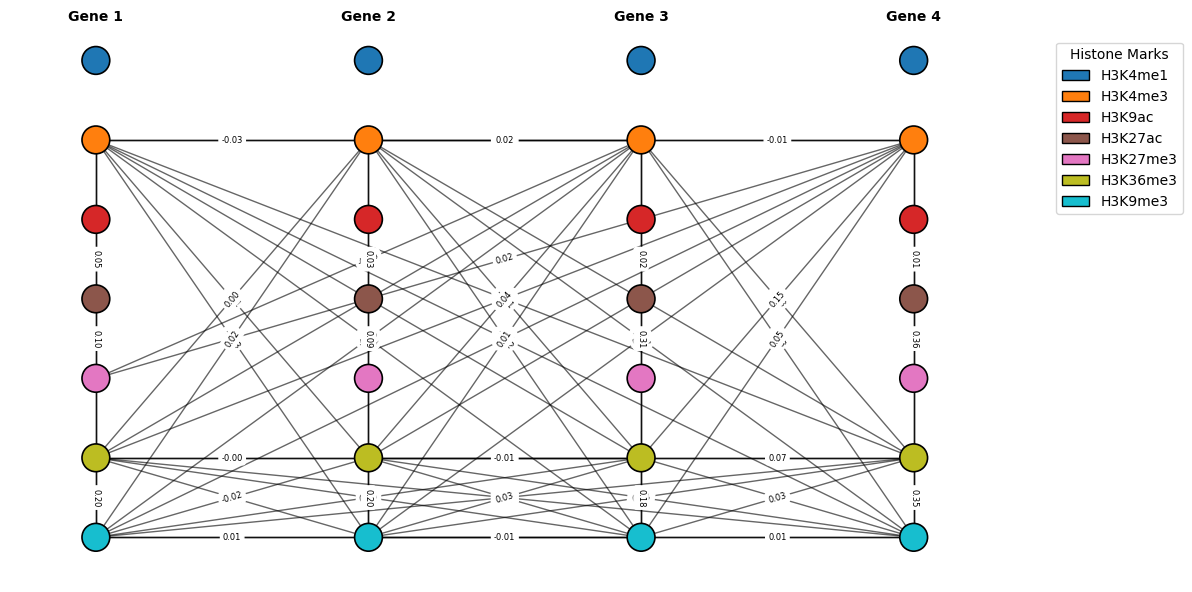

In [ ]:
# gene_names 
gene_names = ["Gene 1", "Gene 2", "Gene 3", "Gene 4"]

plot_graph_layered_final(graph_list[0], gene_names=gene_names)

## Multilayer GNN

In [ ]:
# ==== Utils ====
def safe_div(n, d):
    return float(n) / float(d) if d != 0 else 0.0

def drop_edges(edge_index, edge_attr, p=0.1, training=True):
    if (not training) or (p <= 0):
        return edge_index, edge_attr
    E = edge_index.size(1)
    keep = torch.rand(E, device=edge_index.device) > p
    edge_index = edge_index[:, keep]
    if edge_attr is not None:
        edge_attr = edge_attr[keep]
    return edge_index, edge_attr

def collect_logits_and_labels(model, device, loader):
    model.eval()
    ys, logits = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).view(-1)
            out = torch.nan_to_num(out, nan=0.0, posinf=1e6, neginf=-1e6)
            logits.append(out.detach().cpu())
            ys.append(data.y.view(-1).detach().cpu().float())

    if not ys:
        return np.array([]), np.array([])

    y_true = torch.cat(ys).numpy()
    logit  = torch.cat(logits).numpy()

    m = np.isfinite(y_true) & np.isfinite(logit)
    return y_true[m], logit[m]

def evaluate_auc(model, device, loader):
    y_true, logit = collect_logits_and_labels(model, device, loader)
    if y_true.size == 0 or np.unique(y_true).size < 2:
        return 0.5
    logit = np.clip(logit, -60, 60)
    prob = 1.0 / (1.0 + np.exp(-logit))
    m = np.isfinite(prob) & np.isfinite(y_true)
    y_true, prob = y_true[m], prob[m]
    if y_true.size == 0 or np.unique(y_true).size < 2:
        return 0.5
    return float(roc_auc_score(y_true, prob))

def best_threshold(y_true, prob, metric='f1'):
    ts = np.linspace(0.0, 1.0, 2001)
    best, t_best = -1.0, 0.5
    for t in ts:
        y_hat = (prob >= t).astype(int)
        if metric == 'f1':
            s = f1_score(y_true, y_hat, zero_division=0)
        elif metric == 'youden':
            TP = ((y_hat==1)&(y_true==1)).sum()
            FP = ((y_hat==1)&(y_true==0)).sum()
            TN = ((y_hat==0)&(y_true==0)).sum()
            FN = ((y_hat==0)&(y_true==1)).sum()
            tpr = safe_div(TP, TP+FN); fpr = safe_div(FP, FP+TN)
            s = tpr - fpr
        else:
            s = (y_hat == y_true).mean()
        if s > best:
            best, t_best = s, t
    return float(t_best), float(best)

# ==== Standardizzazione features per fold ====
@torch.no_grad()
def compute_feature_stats(graphs):
    Xs = []
    for g in graphs:
        if hasattr(g, 'x') and g.x is not None:
            Xs.append(g.x.float().cpu())
    X = torch.cat(Xs, dim=0) if len(Xs) else torch.zeros(1, 1)
    mean = X.mean(dim=0)
    std  = X.std(dim=0).clamp_min(1e-6)
    return mean, std

@torch.no_grad()
def apply_standardization(graphs, mean, std):
    for g in graphs:
        if hasattr(g, 'x') and g.x is not None:
            g.x = ((g.x.float() - mean) / std).to(g.x.dtype)

# ==== GINE + JK, BN, Residual, Mean+Max pooling ====
class GINE_JK_Head(torch.nn.Module):
    def __init__(self, in_ch, hidden, num_layers, drop_p=0.3, dropedge_p=0.0, edge_dim=1):
        super().__init__()
        self.dropedge_p = dropedge_p
        self.act = GELU()
        self.dropout = Dropout(drop_p)

        self.input = Linear(in_ch, hidden)

        self.convs = torch.nn.ModuleList()
        self.bns   = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = Sequential(
                Linear(hidden, hidden),
                GELU(),
                Linear(hidden, hidden)
            )
            # usa edge_attr
            self.convs.append(GINEConv(mlp, train_eps=True, edge_dim=edge_dim))
            self.bns.append(BatchNorm1d(hidden))

        self.jk = JumpingKnowledge(mode='cat')
        jk_out_dim = hidden * num_layers

        # head su pooling mean+max 
        self.head = Sequential(
            Linear(jk_out_dim * 2, jk_out_dim),
            GELU(),
            Dropout(drop_p),
            Linear(jk_out_dim, jk_out_dim // 2),
            GELU(),
            Dropout(drop_p),
            Linear(jk_out_dim // 2, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        if self.training and self.dropedge_p > 0.0:
            edge_index, edge_attr = drop_edges(edge_index, edge_attr, p=self.dropedge_p, training=True)

        # sanitize edge_attr -> [B,1]
        if edge_attr is not None:
            ew = torch.nan_to_num(edge_attr, nan=1.0, posinf=1.0, neginf=0.0).view(-1, 1)
        else:
            ew = torch.ones(edge_index.size(1), 1, device=edge_index.device)

        x = self.act(self.input(x))
        xs = []
        for conv, bn in zip(self.convs, self.bns):
            h = conv(x, edge_index, ew)   
            h = bn(h)
            h = self.act(h)
            h = self.dropout(h)
            x = x + h                      
            xs.append(x)

        node_repr = self.jk(xs)            # [N, hidden*num_layers]
        g_mean = global_mean_pool(node_repr, batch)
        g_max  = global_max_pool(node_repr, batch)
        g = torch.cat([g_mean, g_max], dim=1)
        return self.head(g)

# ==== Train step ====
def train_one_epoch(model, device, train_loader, optimizer, criterion, clip_grad=None):
    model.train()
    total = 0.0
    n_batches = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)

        out = model(data.x, data.edge_index, data.edge_attr, data.batch).view(-1)
        out = torch.nan_to_num(out, nan=0.0, posinf=1e6, neginf=-1e6)

        target = data.y.view(-1).float()
        target = torch.nan_to_num(target, nan=0.0, posinf=1.0, neginf=0.0)

        loss = criterion(out, target)
        if torch.isnan(loss) or torch.isinf(loss):
            continue

        loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        total += float(loss.item())
        n_batches += 1
    return total / max(1, n_batches)

# ==== fold split ====
for i, g in enumerate(graph_list):
    g.split = int(df.iloc[i]['split'])  # 1..num_folds

in_channels = graph_list[0].x.size(-1)

# ==== Cross-validation ====
fold_reports = []
for fold in range(1, num_folds + 1):
    print(f"\n===== Fold {fold}/{num_folds} =====")

    test_graphs  = [deepcopy(g) for g in graph_list if g.split == fold]
    pool_graphs  = [deepcopy(g) for g in graph_list if g.split != fold]

    # ---- Validation ----
    y_pool = np.array([int(g.y.item()) for g in pool_graphs])
    idx_pos = np.where(y_pool == 1)[0].tolist()
    idx_neg = np.where(y_pool == 0)[0].tolist()
    rng = np.random.RandomState(42 + fold)
    rng.shuffle(idx_pos); rng.shuffle(idx_neg)

    n_val_pos = max(1, int(len(idx_pos) * val_frac))
    n_val_neg = max(1, int(len(idx_neg) * val_frac))

    val_idx = set(idx_pos[:n_val_pos] + idx_neg[:n_val_neg])
    train_graphs = [pool_graphs[i] for i in range(len(pool_graphs)) if i not in val_idx]
    val_graphs   = [pool_graphs[i] for i in range(len(pool_graphs)) if i in val_idx]

    print(f"Train={len(train_graphs)}  Val={len(val_graphs)}  Test={len(test_graphs)}")

    # ---- Standardizza  ----
    mean_x, std_x = compute_feature_stats(train_graphs)
    apply_standardization(train_graphs, mean_x, std_x)
    apply_standardization(val_graphs,   mean_x, std_x)
    apply_standardization(test_graphs,  mean_x, std_x)

    # ---- DataLoader ===
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_graphs,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_graphs,  batch_size=batch_size, shuffle=False)

    # ---- BCE con pos_weight ----
    y_train = torch.tensor([int(g.y.item()) for g in train_graphs], dtype=torch.float32)
    pos = float((y_train == 1).sum().item())
    neg = float((y_train == 0).sum().item())
    pos_weight = torch.tensor(neg / max(1.0, pos), device=device)

    model = GINE_JK_Head(
        in_ch=in_channels, hidden=hidden_channels, num_layers=num_layers,
        drop_p=dropout_p, dropedge_p=dropedge_p, edge_dim=1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10
    )

    # --- Early stopping F1  ---
    best_score = -1.0
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        loss = train_one_epoch(model, device, train_loader, optimizer, criterion, clip_grad=clip_grad_norm)

        # ---- Val metrics ----
        y_val, logit_val = collect_logits_and_labels(model, device, val_loader)
        if y_val.size:
            prob_val = 1.0 / (1.0 + np.exp(-np.clip(logit_val, -60, 60)))
            t_val, f1_val = best_threshold(y_val, prob_val, metric='f1')
 
            try:
                auc_val = roc_auc_score(y_val, prob_val)
            except ValueError:
                auc_val = float('nan')
            metric_for_es = f1_val
        else:
            t_val, f1_val, auc_val = 0.5, 0.0, float('nan')
            metric_for_es = 0.0

        scheduler.step(metric_for_es)

        print(f"Epoch {epoch:03d} | Loss={loss:.4f} | F1_val={f1_val:.4f} | AUC_val={auc_val if not np.isnan(auc_val) else 'N/A'} | t_val={t_val:.3f}")

        if metric_for_es > best_score + 1e-6:
            best_score = metric_for_es
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_patience:
                print(f"Early stopping at epoch {epoch} (best F1_val={best_score:.4f})")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    # --- Threshold validation F1 ---
    y_val, logit_val = collect_logits_and_labels(model, device, val_loader)
    prob_val = 1.0 / (1.0 + np.exp(-np.clip(logit_val, -60, 60))) if y_val.size else np.array([])
    t_star, _ = best_threshold(y_val, prob_val, metric='f1') if y_val.size else (0.5, 0.0)

    # --- test @ t* ---
    y_test, logit_test = collect_logits_and_labels(model, device, test_loader)
    prob_test = 1.0 / (1.0 + np.exp(-np.clip(logit_test, -60, 60))) if y_test.size else np.array([])

    if y_test.size:
        y_hat = (prob_test >= t_star).astype(int)
        TP = int(((y_hat==1)&(y_test==1)).sum())
        FP = int(((y_hat==1)&(y_test==0)).sum())
        TN = int(((y_hat==0)&(y_test==0)).sum())
        FN = int(((y_hat==0)&(y_test==1)).sum())
        precision = safe_div(TP, TP+FP)
        recall    = safe_div(TP, TP+FN)
        f1        = safe_div(2*precision*recall, precision+recall)
        acc       = safe_div(TP+TN, TP+FP+TN+FN)
        try:
            auc = roc_auc_score(y_test, prob_test)
        except ValueError:
            auc = None
    else:
        precision = recall = f1 = acc = 0.0
        auc = None

    print(f"\n===== Fold {fold} results (t*={t_star:.3f}) =====")
    print(f"Test Acc={acc:.10f} | Prec={precision:.10f} | Rec={recall:.10f} | F1={f1:.10f} | AUC={auc if auc is not None else 'N/A'}")

    fold_reports.append({
        "acc": acc, "prec": precision, "rec": recall, "f1": f1,
        "auc": (auc if auc is not None else float('nan')),
        "t_star": t_star
    })

# ==== Report ====
def agg(key):
    vals = np.array([r[key] for r in fold_reports], dtype=float)
    if key == "auc":
        vals = vals[~np.isnan(vals)]
    return float(np.mean(vals)) if vals.size else float('nan'), float(np.std(vals)) if vals.size else float('nan')

m_acc, s_acc = agg("acc")
m_pre, s_pre = agg("prec")
m_rec, s_rec = agg("rec")
m_f1,  s_f1  = agg("f1")
m_auc, s_auc = agg("auc") if any(not np.isnan(r["auc"]) for r in fold_reports) else (float('nan'), float('nan'))
m_t,   s_t   = agg("t_star")

print("\n===== Averages over folds (Test @ t* from val) =====")
print(f"Acc: {m_acc:.10f} ± {s_acc:.4f}")
print(f"Prec:{m_pre:.10f} ± {s_pre:.4f}")
print(f"Rec: {m_rec:.10f} ± {s_rec:.4f}")
print(f"F1:  {m_f1:.10f} ± {s_f1:.4f}")
print(f"AUC: {m_auc:.10f} ± {s_auc:.4f}" if not np.isnan(m_auc) else "AUC: N/A")
print(f"t*:  {m_t:.3f} ± {s_t:.3f}")


===== Fold 1/4 =====
Train=7335  Val=1294  Test=3186
Epoch 001 | Loss=0.3168 | F1_val=0.9022 | AUC_val=0.9305136639676114 | t_val=0.237
Epoch 002 | Loss=0.2670 | F1_val=0.9002 | AUC_val=0.920134109311741 | t_val=0.534
Epoch 003 | Loss=0.2643 | F1_val=0.9038 | AUC_val=0.9308400809716597 | t_val=0.418
Epoch 004 | Loss=0.2624 | F1_val=0.9017 | AUC_val=0.9309362348178137 | t_val=0.278
Epoch 005 | Loss=0.2614 | F1_val=0.9041 | AUC_val=0.930748987854251 | t_val=0.363
Epoch 006 | Loss=0.2550 | F1_val=0.9008 | AUC_val=0.9295748987854251 | t_val=0.545
Epoch 007 | Loss=0.2556 | F1_val=0.9037 | AUC_val=0.9320546558704452 | t_val=0.404
Epoch 008 | Loss=0.2571 | F1_val=0.9023 | AUC_val=0.9315637651821862 | t_val=0.497
Epoch 009 | Loss=0.2503 | F1_val=0.9061 | AUC_val=0.9269762145748989 | t_val=0.442
Epoch 010 | Loss=0.2521 | F1_val=0.9013 | AUC_val=0.9289296558704453 | t_val=0.201
Epoch 011 | Loss=0.2444 | F1_val=0.9011 | AUC_val=0.9273608299595142 | t_val=0.442
Epoch 012 | Loss=0.2430 | F1_val=0.